# Objective

Demonstrate how self training can be used to supplement ML classification accuracy when a majority of the data available are unlabeled.

20% of data set aside as test set

20% of data kept as labeled train set

60% of data designated as 'unlabeled' - labels removed


# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

# Obtain Data

In [2]:
# Load data

df = pd.read_csv('surgical_deepnet.csv')
df.head()

,bmi,Age,asa_status,baseline_cancer,baseline_charlson,baseline_cvd,baseline_dementia,baseline_diabetes,baseline_digestive,baseline_osteoart,...,complication_rsi,dow,gender,hour,month,moonphase,mort30,mortality_rsi,race,complication
0,19.31,59.2,1,1,0,0,0,0,0,0,...,-0.57,3,0,7.63,6,1,0,-0.43,1,0
1,18.73,59.1,0,0,0,0,0,0,0,0,...,0.21,0,0,12.93,0,1,0,-0.41,1,0
2,21.85,59.0,0,0,0,0,0,0,0,0,...,0.00,2,0,7.68,5,3,0,0.08,1,0
3,18.49,59.0,1,0,1,0,0,1,1,0,...,-0.65,2,1,7.58,4,3,0,-0.32,1,0
4,19.70,59.0,1,0,0,0,0,0,0,0,...,0.00,0,0,7.88,11,0,0,0.00,1,0


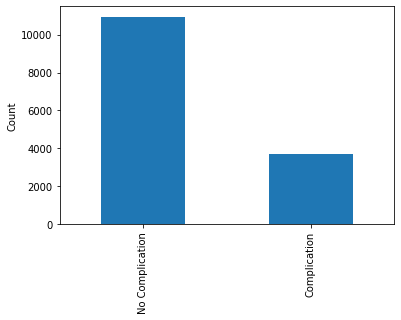

In [16]:
# Visualize class distribution

df.complication.value_counts().plot(kind='bar')
plt.xticks([0,1], ['No Complication', 'Complication'])
plt.ylabel('Count');

# Scrub Data

In [3]:
# Shuffle the data

df = df.sample(frac=1, random_state=15).reset_index(drop=True)

In [4]:
# Generate indices for splits

test_ind = round(len(df)*0.25)
train_ind = test_ind + round(len(df)*0.01)
unlabeled_ind = train_ind + round(len(df)*0.74)

In [5]:
# Partition the data

test = df.iloc[:test_ind]
train = df.iloc[test_ind:train_ind]
unlabeled = df.iloc[train_ind:unlabeled_ind]

In [6]:
# Assign data to train, test, and unlabeled sets

X_train = train.drop('complication', axis=1)
y_train = train.complication

X_unlabeled = unlabeled.drop('complication', axis=1)

X_test = test.drop('complication', axis=1)
y_test = test.complication

In [7]:
X_train.shape, y_train.shape

((146, 24), (146,))

In [8]:
X_test.shape, y_test.shape

((3659, 24), (3659,))

In [9]:
X_unlabeled.shape

(10830, 24)

# Initial Model

In [10]:
# Logistic Regression Classifier

clf = LogisticRegression(max_iter=1000)

clf.fit(X_train, y_train)
y_hat_test = clf.predict(X_test)
y_hat_train = clf.predict(X_train)

In [11]:
train_f1 = f1_score(y_train, y_hat_train)
test_f1 = f1_score(y_test, y_hat_test)

print(f"Train f1 Score: {train_f1}")
print(f"Test f1 Score: {test_f1}")

Train f1 Score: 0.5846153846153846
Test f1 Score: 0.5002908667830134


In [12]:
confusion_matrix(y_test, y_hat_test)

array([[2370,  380],
       [ 479,  430]], dtype=int64)

# Self Training Algorithm

# Self training procedure using Logistic Regression Classifier

In [13]:
iterations = 0
train_f1s = []
test_f1s = []
high_prob = [1] 
while len(high_prob) > 0:
        
    # Fit classifier and make train/test predictions
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    y_hat_train = clf.predict(X_train)
    y_hat_test = clf.predict(X_test)


    train_f1 = f1_score(y_train, y_hat_train)
    test_f1 = f1_score(y_test, y_hat_test)
    print(f"Iteration {iterations}")
    print(f"Train f1: {train_f1}")
    print(f"Test f1: {test_f1}")
    train_f1s.append(train_f1)
    test_f1s.append(test_f1)
        
    print(f"Now predicting labels for unlabeled data...")

    pred_probs = clf.predict_proba(X_unlabeled)
    preds = clf.predict(X_unlabeled)
    prob_0 = pred_probs[:,0]
    prob_1 = pred_probs[:,1]

    df_pred_prob = pd.DataFrame([])
    df_pred_prob['preds'] = preds
    df_pred_prob['prob_0'] = prob_0
    df_pred_prob['prob_1'] = prob_1
    df_pred_prob.index = X_unlabeled.index
    
    high_prob = pd.concat([df_pred_prob.loc[df_pred_prob['prob_0'] > 0.99],
                           df_pred_prob.loc[df_pred_prob['prob_1'] > 0.99]],
                          axis=0)
    
    print(f"{len(high_prob)} high-probability predictions added to training data.")
    
   

    X_train = pd.concat([X_train, X_unlabeled.loc[high_prob.index]], axis=0)
    y_train = pd.concat([y_train, high_prob.preds])      
    X_unlabeled = X_unlabeled.drop(index=high_prob.index)
    print(f"{len(X_unlabeled)} unlabeled instances remaining.")
          
    iterations += 1
          
    print("\n")

Iteration 0
Train f1: 0.5846153846153846
Test f1: 0.5002908667830134
Now predicting labels for unlabeled data...
42 high-probability predictions added to training data.
10788 unlabeled instances remaining.


Iteration 1
Train f1: 0.7627118644067796
Test f1: 0.5037463976945246
Now predicting labels for unlabeled data...
30 high-probability predictions added to training data.
10758 unlabeled instances remaining.


Iteration 2
Train f1: 0.8181818181818182
Test f1: 0.505431675242996
Now predicting labels for unlabeled data...
20 high-probability predictions added to training data.
10738 unlabeled instances remaining.


Iteration 3
Train f1: 0.847457627118644
Test f1: 0.5076835515082526
Now predicting labels for unlabeled data...
21 high-probability predictions added to training data.
10717 unlabeled instances remaining.


Iteration 4
Train f1: 0.8615384615384616
Test f1: 0.5096262740656852
Now predicting labels for unlabeled data...
22 high-probability predictions added to training data.
1

Iteration 40
Train f1: 0.9475587703435805
Test f1: 0.5254054054054054
Now predicting labels for unlabeled data...
1 high-probability predictions added to training data.
10083 unlabeled instances remaining.


Iteration 41
Train f1: 0.9475587703435805
Test f1: 0.5272825499729876
Now predicting labels for unlabeled data...
1 high-probability predictions added to training data.
10082 unlabeled instances remaining.


Iteration 42
Train f1: 0.9475587703435805
Test f1: 0.5262020529443544
Now predicting labels for unlabeled data...
2 high-probability predictions added to training data.
10080 unlabeled instances remaining.


Iteration 43
Train f1: 0.947935368043088
Test f1: 0.5275675675675675
Now predicting labels for unlabeled data...
1 high-probability predictions added to training data.
10079 unlabeled instances remaining.


Iteration 44
Train f1: 0.9481216457960644
Test f1: 0.5259179265658748
Now predicting labels for unlabeled data...
0 high-probability predictions added to training data.


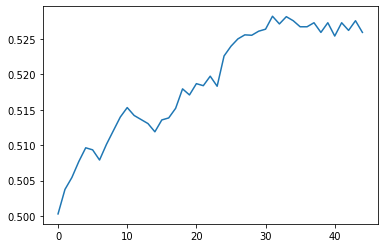

In [14]:
plt.plot(range(iterations), test_f1s);
# plt.plot(range(iterations), train_f1s);

In [15]:
confusion_matrix(y_test, y_hat_test)

array([[2294,  456],
       [ 422,  487]], dtype=int64)